### Integration + Clustering + Differential Expression Analysis 

Data integration using DESC https://www.nature.com/articles/s41467-020-15851-3 

DESC intregrates different dataset of single cell experiment performing batch correction and after integration

As covariate of batch correction we used the metadata dataset, so the covarariates considered were 3 (10X 3' V2, 10X 5' V2, cellseq )  

In [ ]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
import scanorama

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.2


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/singlecell/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

# 0 Data import 

DESC algorithm was performed tuning this parameters, Resolution and KNN

Resolution modify the clustering while the KNN modify the batch correction.

In [4]:
adata = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/NotCorrected_T_cell.h5ad")

In [5]:
adataR08K10 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R08_cell.h5ad")
adataR06K10 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_cell.h5ad")
adataR06K20 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_K20_cell.h5ad")
adataR06K30 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_K30_cell.h5ad")

In [ ]:
sc.tl.louvain(adataR06K10,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)
sc.tl.louvain(adataR06K20,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)
sc.tl.louvain(adataR06K30,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)
sc.tl.louvain(adataR08K10,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)
sc.tl.louvain(adata,resolution=0.6, key_added= 'leiden_r6_clusters',random_state=10)

In [144]:
adataR06K20 = sc.read_h5ad("/mnt/lugli/SP028_Autoimmunity/h5_files/Desc_R06_K20_cell.h5ad")

In [6]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# 1 Clustering

### Desc With Louvain Resolution 0.8 and 0.6

<AxesSubplot:title={'center':'Desc Res 0.6'}, xlabel='UMAP1', ylabel='UMAP2'>

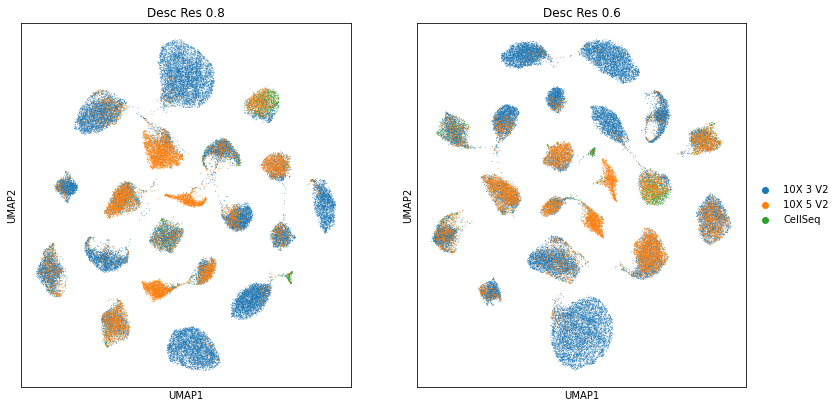

In [170]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(33/2.54, 17/2.54))
sc.pl.umap(adataR08K10, color="dataset", title="Desc Res 0.8",ax=ax1,legend_loc=None,  show=False)
sc.pl.umap(adataR06K10, color="dataset", title="Desc Res 0.6",ax=ax2,  show=False)

### Desc With Louvain Resolution 0.6 and KNN 10 / 20 /  30

<AxesSubplot:title={'center':'Desc Res 0.6 K30'}, xlabel='UMAP1', ylabel='UMAP2'>

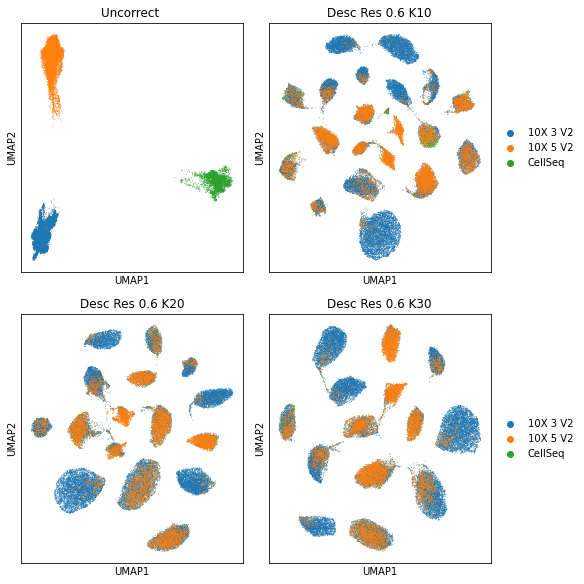

In [171]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.umap(adata, color="dataset", title="Uncorrect ", ax=axs[0,0],legend_loc=None, show=False)
sc.pl.umap(adataR06K10, color="dataset", title="Desc Res 0.6 K10", ax=axs[0,1], show=False)
sc.pl.umap(adataR06K20, color="dataset", title="Desc Res 0.6 K20",legend_loc=None, ax=axs[1,0], show=False)
sc.pl.umap(adataR06K30, color="dataset", title="Desc Res 0.6 K30", ax=axs[1,1], show=False)

In [142]:
adata.obs['CellFromTumor'] = ['Autoimmune' if loc == 0 else 'Tumor' for loc in adata.obs['CellFromTumor']]
adataR06K10.obs['CellFromTumor'] = ['Autoimmune' if loc == 0 else 'Tumor' for loc in adataR06K10.obs['CellFromTumor']]
adataR06K20.obs['CellFromTumor'] = ['Autoimmune' if loc == 0 else 'Tumor' for loc in adataR06K20.obs['CellFromTumor']]
adataR08K10.obs['CellFromTumor'] = ['Autoimmune' if loc == 0 else 'Tumor' for loc in adataR08K10.obs['CellFromTumor']]
adataR06K30.obs['CellFromTumor'] = ['Autoimmune' if loc == 0 else 'Tumor' for loc in adataR06K30.obs['CellFromTumor']]

### UMAP plot labeling Autoimmune and Tumor cells 

... storing 'CellFromTumor' as categorical


<AxesSubplot:title={'center':'Desc Res 0.8 K30'}, xlabel='UMAP1', ylabel='UMAP2'>

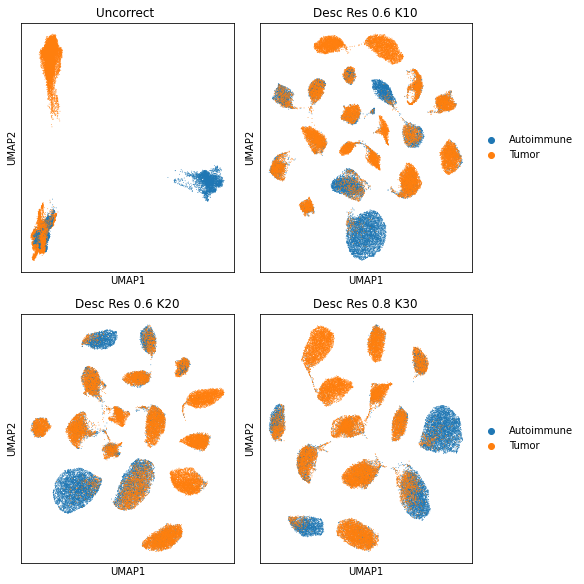

In [177]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.umap(adata, color="CellFromTumor", title="Uncorrect ",legend_loc=None, ax=axs[0,0], show=False)
sc.pl.umap(adataR06K10, color="CellFromTumor", title="Desc Res 0.6 K10", ax=axs[0,1], show=False)
sc.pl.umap(adataR06K20, color="CellFromTumor", title="Desc Res 0.6 K20", ax=axs[1,0],legend_loc=None, show=False)
sc.pl.umap(adataR06K30, color="CellFromTumor", title="Desc Res 0.8 K30", ax=axs[1,1], show=False)

<AxesSubplot:title={'center':'Desc Res 0.6 K30 CD4 expression'}, xlabel='UMAP1', ylabel='UMAP2'>

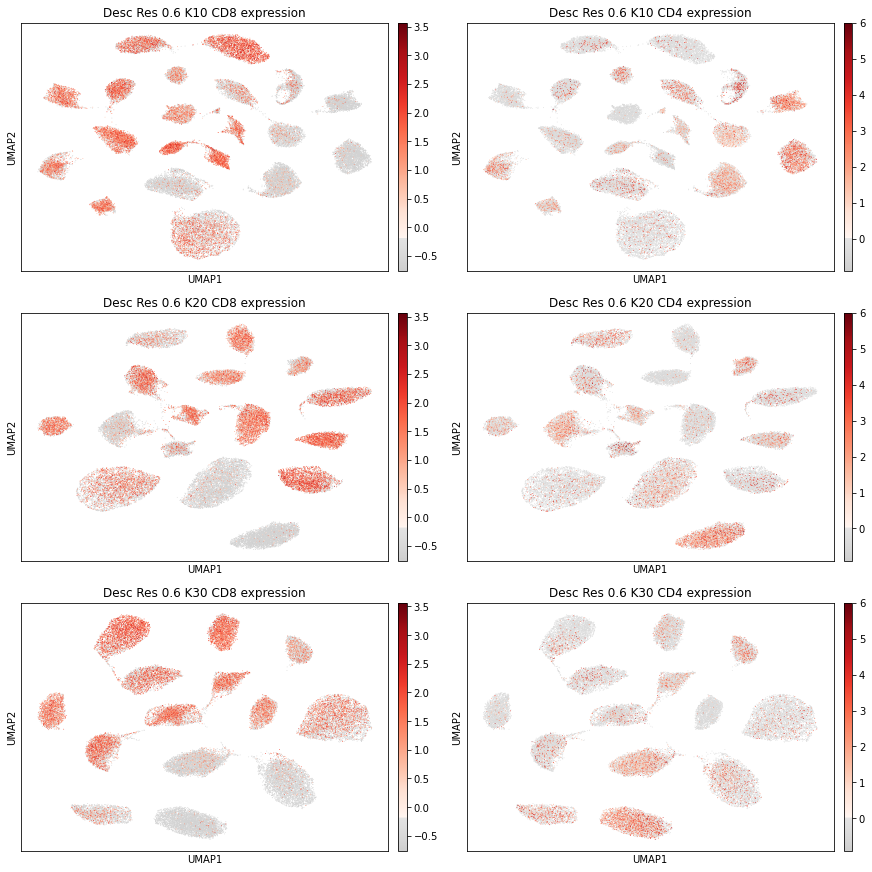

In [188]:
fig, axs = plt.subplots(3, 2, figsize=(12,12),constrained_layout=True)
sc.pl.umap(adataR06K10, color=['CD8A'],color_map=mymap, title="Desc Res 0.6 K10 CD8 expression", ax=axs[0,0],use_raw=False,legend_loc=None, show=False)
sc.pl.umap(adataR06K10, color=['CD4'],color_map=mymap, title="Desc Res 0.6 K10 CD4 expression", ax=axs[0,1],use_raw=False, show=False)
sc.pl.umap(adataR06K20, color=['CD8A'],color_map=mymap, title="Desc Res 0.6 K20 CD8 expression",legend_loc=None,use_raw=False, ax=axs[1,0], show=False)
sc.pl.umap(adataR06K20, color=['CD4'],color_map=mymap, title="Desc Res 0.6 K20 CD4 expression", ax=axs[1,1],use_raw=False, show=False)
sc.pl.umap(adataR06K30, color=['CD8A'],color_map=mymap, title="Desc Res 0.6 K30 CD8 expression",legend_loc=None,use_raw=False, ax=axs[2,0], show=False)
sc.pl.umap(adataR06K30, color=['CD4'],color_map=mymap, title="Desc Res 0.6 K30 CD4 expression", ax=axs[2,1],use_raw=False, show=False)

### Umap plot of clusters

<AxesSubplot:title={'center':'Desc Res 0.6 K30'}, xlabel='UMAP1', ylabel='UMAP2'>

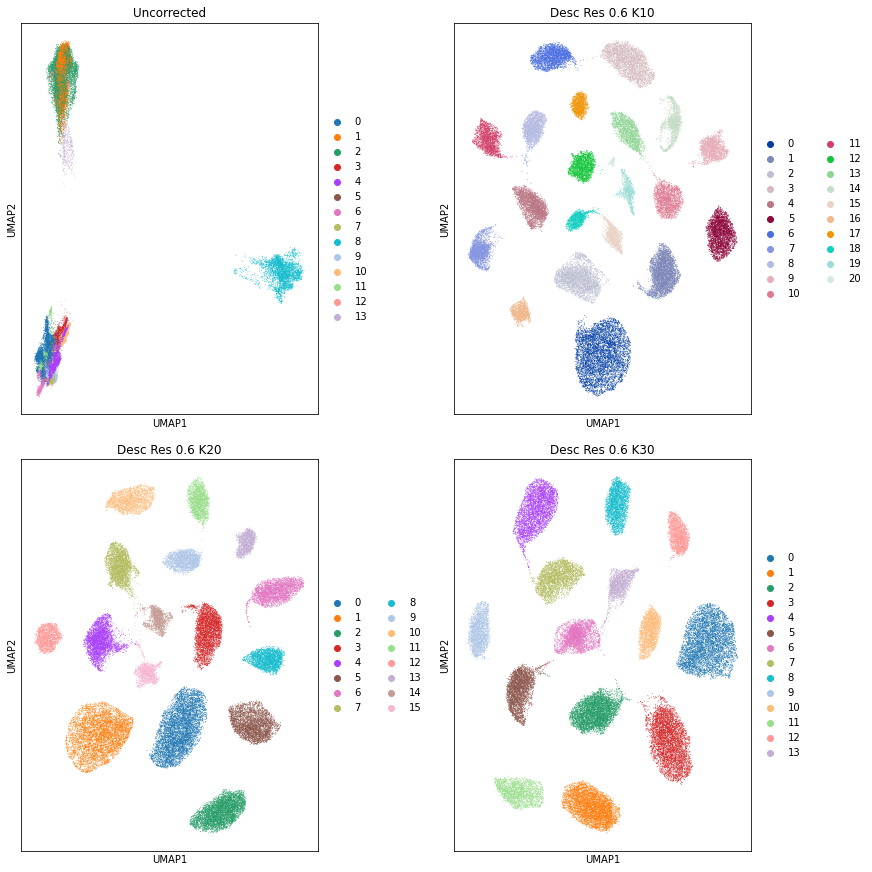

In [193]:
fig, axs = plt.subplots(2, 2, figsize=(12,12),constrained_layout=True)
sc.pl.umap(adata, color="leiden_r6_clusters", title="Uncorrected", ax=axs[0,0], show=False)
sc.pl.umap(adataR06K10, color="leiden_r6_clusters", title="Desc Res 0.6 K10", ax=axs[0,1], show=False)
sc.pl.umap(adataR06K20, color="leiden_r6_clusters", title="Desc Res 0.6 K20", ax=axs[1,0], show=False)
sc.pl.umap(adataR06K30, color="leiden_r6_clusters", title="Desc Res 0.6 K30", ax=axs[1,1], show=False)

### Follow steps are performed with Resolution 0.6 and KNN 20 

/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


<AxesSubplot:title={'center':'Desc Res 0.6 K20'}, xlabel='UMAP1', ylabel='UMAP2'>

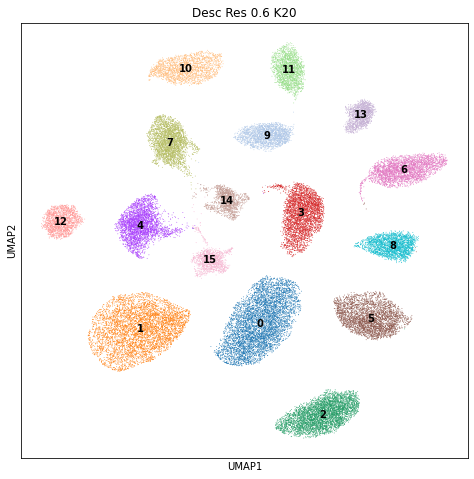

In [79]:
sc.pl.umap(adataR06K20, color="leiden_r6_clusters", title="Desc Res 0.6 K20",legend_loc="on data", show=False)

### Umap plot + stacked barplot of TumorType / Sample Type / Technology

In [ ]:
fig, (ax1) = plt.subplots(2,2, figsize=(33/2.54, 17/2.54))

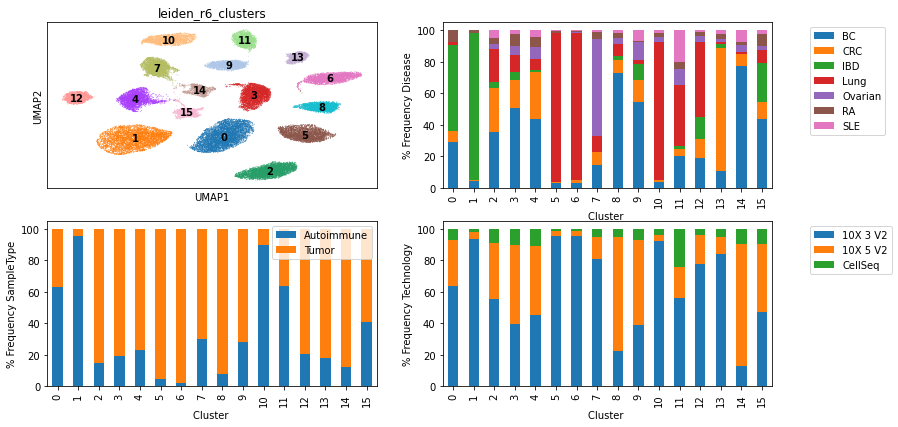

In [245]:
#fig, (ax1,ax2,ax3,ax4) = plt.subplots(2,2, figsize=(33/2.54, 17/2.54))
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(33/2.54, 17/2.54))
sc.pl.umap(adataR06K20, color="leiden_r6_clusters",legend_loc="on data",ax=ax1, show=False)
ax2 = adataR06K20.obs.groupby("leiden_r6_clusters")["TumorType"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax2)
ax2.set_xlabel("Cluster ")
ax2.set_ylabel("% Frequency Disease")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))
ax3 = adataR06K20.obs.groupby("leiden_r6_clusters")["CellFromTumor"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax3)
ax3.set_xlabel("Cluster ")
ax3.set_ylabel("% Frequency SampleType")
ax3.grid(False)
ax3.legend()
ax4 = adataR06K20.obs.groupby("leiden_r6_clusters")["dataset"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax4)
ax4.set_xlabel("Cluster ")
ax4.set_ylabel("% Frequency Technology")
ax4.grid(False)
ax4.legend(bbox_to_anchor=(1.1, 1.0))

In [261]:
#adataR06K20.obs[['CellFromTumor','TumorType']].to_csv("/home/spuccio/isilon/SP028_Autoimmunity/cellfromtum.csv",sep="\t",header=True,index=True)
df = pd.read_csv("/home/spuccio/isilon/SP028_Autoimmunity/d.csv",sep="\t",header=0,index_col=0)

In [264]:
df.head()


,CellFromTumor,TumorType
S006_L1Q1_A01-0-0,Autoimmune,RA
S006_L1Q1_A03-0-0,Autoimmune,RA
S006_L1Q1_A05-0-0,Autoimmune,RA
S006_L1Q1_A07-0-0,Autoimmune,RA
S006_L1Q1_A09-0-0,Autoimmune,RA


In [265]:
adataR06K20.obs[]

,CellId,CellFromTumor,PatientNumber,TumorType,TumorSite,CellType,batch,n_counts,log_counts,n_genes,...,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,percent_ribo,percent_mito,dataset,desc_0.6,leiden_r6_clusters
S006_L1Q1_A01-0-0,S006_L1Q1_A01,Autoimmune,301-0159,RA,SynovialFluid,T cell,CellSeq,1358.0,7.213768,758,...,7.214504,38.733432,46.980854,58.910162,81.001473,0.041973,0.194404,CellSeq,11,7
S006_L1Q1_A03-0-0,S006_L1Q1_A03,Autoimmune,301-0159,RA,SynovialFluid,T cell,CellSeq,2614.0,7.868637,1200,...,7.869020,35.309870,45.332823,56.197399,73.221117,0.123183,0.171385,CellSeq,0,4
S006_L1Q1_A05-0-0,S006_L1Q1_A05,Autoimmune,301-0159,RA,SynovialFluid,T cell,CellSeq,3891.0,8.266421,1639,...,8.266679,33.898741,42.302750,51.811874,69.082498,0.059882,0.174248,CellSeq,11,7
S006_L1Q1_A07-0-0,S006_L1Q1_A07,Autoimmune,301-0159,RA,SynovialFluid,T cell,CellSeq,2254.0,7.720462,1270,...,7.720905,25.377107,34.205856,45.430346,65.838509,0.045697,0.097604,CellSeq,5,2
S006_L1Q1_A09-0-0,S006_L1Q1_A09,Autoimmune,301-0159,RA,SynovialFluid,T cell,CellSeq,3304.0,8.102889,1563,...,8.103191,27.935835,36.440678,47.094431,66.767554,0.067494,0.108656,CellSeq,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sc5rJUQ060_TTTGGTTGTGTGAAAT-3-6,sc5rJUQ060_TTTGGTTGTGTGAAAT,Tumor,53,BC,Biopsy,T cell,10X 5 V2,5386.0,8.591558,1716,...,8.591743,39.639807,54.251764,64.611957,77.033049,0.398812,0.043075,10X 5 V2,2,0
sc5rJUQ060_TTTGGTTTCACGACTA-3-6,sc5rJUQ060_TTTGGTTTCACGACTA,Tumor,53,BC,Biopsy,T cell,10X 5 V2,5006.0,8.518393,1959,...,8.518592,32.261286,44.007191,54.834199,69.117060,0.272273,0.018777,10X 5 V2,5,2
sc5rJUQ060_TTTGGTTTCGCAAGCC-3-6,sc5rJUQ060_TTTGGTTTCGCAAGCC,Tumor,53,BC,Biopsy,T cell,10X 5 V2,1942.0,7.571474,964,...,7.571989,33.625129,46.549949,58.805355,76.107106,0.290937,0.031411,10X 5 V2,4,3
sc5rJUQ060_TTTGTCACAAACTGCT-3-6,sc5rJUQ060_TTTGTCACAAACTGCT,Tumor,53,BC,Biopsy,T cell,10X 5 V2,3464.0,8.150179,1396,...,8.150468,37.817552,51.154734,61.316397,74.133949,0.308891,0.070727,10X 5 V2,4,3


In [ ]:
ax3 = adataR06K20.obs.groupby("leiden_r6_clusters")["TumorType"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax3)
ax3.set_xlabel("Main Cell Type ")
ax3.set_ylabel("% Frequency")
ax3.grid(False)
ax3.legend(bbox_to_anchor=(1.1, 1.0))
ax2 = adataR06K20.obs.groupby("leiden_r6_clusters")["dataset"].value_counts(normalize=True).mul(100).unstack().plot.bar(stacked=True,legend=False,ax=ax4)
ax2.set_xlabel("Main Cell Type ")
ax2.set_ylabel("% Frequency")
ax2.grid(False)
ax2.legend(bbox_to_anchor=(1.1, 1.0))

### CD4 CD8 expression of Setup selected (Res 0.6 KNN 20) (same as plot above but with more zoom)

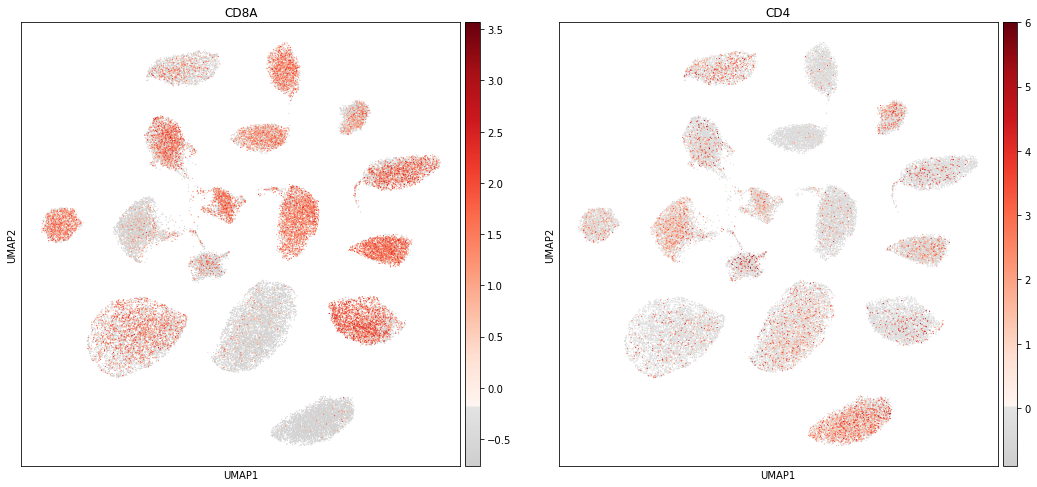

In [194]:
sc.pl.umap(adataR06K20, color=['CD8A','CD4'],color_map=mymap,use_raw=False,s=5); plt.show()

# 2 Differential Expression

In [195]:
sc.tl.rank_genes_groups(adataR06K10, 'leiden_r6_clusters', method='wilcoxon',key_added = "leiden_r6_clusters_wilcoxon",use_raw=False)
sc.tl.rank_genes_groups(adataR06K30, 'leiden_r6_clusters', method='wilcoxon',key_added = "leiden_r6_clusters_wilcoxon",use_raw=False)
sc.tl.rank_genes_groups(adataR06K20, 'leiden_r6_clusters', method='wilcoxon',key_added = "leiden_r6_clusters_wilcoxon",use_raw=False)

ranking genes


/home/spuccio/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


    finished: added to `.uns['leiden_r6_clusters_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:52)
ranking genes
    finished: added to `.uns['leiden_r6_clusters_wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:04)


In [233]:
result = adataR06K20_2.uns['leiden_r6_clusters_wilcoxon']
groups = result['names'].dtype.names
degs =pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

In [234]:
degs

,0_n,0_p,0_l,1_n,1_p,1_l,2_n,2_p,2_l,3_n,...,12_l,13_n,13_p,13_l,14_n,14_p,14_l,15_n,15_p,15_l
0,RPS3A,0.0,17.260796,IGHA1,0.0,4.455921,TNFRSF4,0.0,5.575254,GZMK,...,14.268577,MT-ATP6,0.000000e+00,24.934937,VIM,0.000000e+00,11.668445,MT-ATP8,7.709649e-11,-0.233523
1,RPS6,0.0,11.400444,IL7R,0.0,6.103785,LTB,0.0,5.349672,CST7,...,17.933662,MT-CO1,0.000000e+00,38.186161,HLA-B,0.000000e+00,21.320074,MTRNR2L12,8.185337e-11,1.042231
2,RPS8,0.0,12.355469,TNFAIP3,0.0,4.885371,TIGIT,0.0,2.813319,GZMA,...,31.485603,MT-CO2,2.323996e-305,28.456682,HLA-C,3.871116e-256,11.626567,MT-ND4L,2.826390e-09,0.069008
3,TPT1,0.0,12.230224,KLRB1,0.0,9.085340,BATF,0.0,3.440204,CCL5,...,14.963334,MT-CO3,2.326077e-285,24.144373,HLA-A,2.830144e-248,13.758959,MTRNR2L8,2.521429e-04,0.597113
4,RPS12,0.0,19.180895,NFKBIA,0.0,6.355811,CD27,0.0,2.378195,NKG7,...,13.377282,MT-ND4,2.368008e-266,16.053297,MT-ND4L,2.799809e-221,8.586272,GOLGA8B,7.527150e-01,0.078197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18928,HLA-B,0.0,-10.426597,TMSB10,0.0,-10.788075,ANXA1,0.0,-3.479771,RPS20,...,-2.386068,CXCR4,1.687045e-77,-3.370911,RPS10,9.519376e-44,-1.375346,RPS6,0.000000e+00,-12.831924
18929,CCL4,0.0,-10.923440,HLA-B,0.0,-12.715166,CCL4,0.0,-10.113596,ID2,...,-6.932417,BTG1,2.069291e-84,-3.775205,RPL13A,9.137014e-46,-6.532810,RPL23A,0.000000e+00,-10.160469
18930,NKG7,0.0,-9.255816,CD74,0.0,-6.369974,NKG7,0.0,-8.345519,S100A4,...,-5.072305,HLA-A,2.242317e-95,-6.118515,RGS1,6.509320e-76,-3.441842,RPL15,0.000000e+00,-7.892895
18931,GZMA,0.0,-6.912271,HLA-C,0.0,-9.452615,GZMA,0.0,-5.983857,CD7,...,-3.024688,HLA-B,9.837865e-102,-7.999969,TSC22D3,3.297916e-76,-2.516606,B2M,0.000000e+00,-47.424534


In [222]:
degs.head(500)to_csv("/mnt/lugli/SP028_Autoimmunity/Table/Res06_KNN20_integrated_MarkerGenes.csv",sep="\t",header=True,index=False)

SyntaxError: invalid syntax (<ipython-input-222-311efb043b6c>, line 1)

In [223]:
result = adataR06K10.uns['leiden_r6_clusters_wilcoxon']
groups = result['names'].dtype.names
degs =pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})

In [224]:
degs.head(500).to_csv("/mnt/lugli/SP028_Autoimmunity/Table/Res06_KNN10_integrated_MarkerGenes.csv",sep="\t",header=True,index=False)

In [225]:
result = adataR06K30.uns['leiden_r6_clusters_wilcoxon']
groups = result['names'].dtype.names
degs =pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})

In [232]:
adataR06K10.obs['leiden_r6_clusters']

S006_L1Q1_A01-0-0                  14
S006_L1Q1_A03-0-0                  10
S006_L1Q1_A05-0-0                  10
S006_L1Q1_A07-0-0                  14
S006_L1Q1_A09-0-0                  10
                                   ..
sc5rJUQ060_TTTGGTTGTGTGAAAT-3-6     1
sc5rJUQ060_TTTGGTTTCACGACTA-3-6     9
sc5rJUQ060_TTTGGTTTCGCAAGCC-3-6     4
sc5rJUQ060_TTTGTCACAAACTGCT-3-6     4
sc5rJUQ060_TTTGTCACAGCTGCTG-3-6     5
Name: leiden_r6_clusters, Length: 44709, dtype: category
Categories (21, object): ['0', '1', '2', '3', ..., '17', '18', '19', '20']

In [226]:
degs.head(500).to_csv("/mnt/lugli/SP028_Autoimmunity/Table/Res06_KNN30_integrated_MarkerGenes.csv",sep="\t",header=True,index=False)

### Save data

In [116]:
adataR06K20.write("/mnt/lugli/SP028_Autoimmunity/h5_files/adataR06K20_clustered_louvain06.h5ad")

In [128]:
import loompy as lp
import numpy as np

row_attrs = { 
    "Gene": np.array(adataR06K20.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adataR06K20.obs.index) ,
    "nGene": np.array( np.sum(adataR06K20.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adataR06K20.X.transpose() , axis=0)).flatten() ,
}
lp.create( "/mnt/lugli/SP028_Autoimmunity/pyscenic/adataR06K20.loom", adataR06K20.X.transpose(), row_attrs, col_attrs )

In [133]:
adataR06K20.obs['leiden_r6_clusters'].to_csv("/mnt/lugli/SP028_Autoimmunity/pyscenic/adataR06K20_clusters.csv",header=False,index=True)